- Student name: Duy Hieu Nguyen
- SID: 33694052

# 2. **Perceptron vs Neural Networks**

## Question 2. Neural Network’s Decision Boundary

### **Task 1:  Load data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('Task2B_train.csv')
test_data = pd.read_csv('Task2B_test.csv')

# Get feature, label from test and train set
x_train = train_data[['feature1', 'feature2']].values
y_train = train_data['label'].values

x_test = test_data[['feature1', 'feature2']].values
y_test = test_data['label'].values

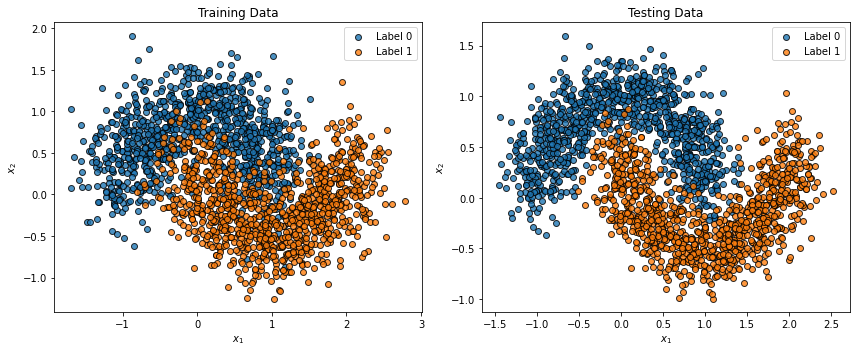

In [2]:
def scatter_data_by_target_value(x, y, ax=None, scatter_params={'ec': 'black', 'alpha': 0.8}):
    ax = plt.gca() if ax is None else ax
    for c in range(2):
        x1_c = x[y==c, 0]
        x2_c = x[y==c, 1]
        ax.scatter(x1_c, x2_c, label=f'Label {c}', **scatter_params)
    
    ax.legend()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

# Testing the modified function
plt.figure(figsize=(12, 5))

# Plot for training data
plt.subplot(1, 2, 1)
scatter_data_by_target_value(x_train, y_train)
plt.title('Training Data')

# Plot for testing data
plt.subplot(1, 2, 2)
scatter_data_by_target_value(x_test, y_test)
plt.title('Testing Data')

plt.tight_layout()
plt.show()


### **Task 2: Perceptron**


In [3]:
import numpy as np
class Perceptron:
    
    def __init__(self, eta=0.01, tau_max=10000, epsilon=0.005, random_state=None):
        self.eta = eta   # learning rate
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # tolerable error
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape

        self.w_trace_ = np.empty((self.tau_max, p))     # trace of weights during training
        self.xy_idx_trace_ = np.empty(self.tau_max, int) # trace of considered training point indices
        
        # initialisation of iteration counter and weights
        tau = 0 
        self.w_ = self.w_trace_[0,:] = RNG.normal(size=p) 
        terminate = False
        while not (terminate or (self.predict(x)!=y).mean()<self.epsilon):
            # random order to consider training data
            order = RNG.choice(np.arange(n),size = n ,replace = False)
            for i in range(n):
                if self.predict(x[order][i]) != y[order][i]:
                    self.w_ = self.w_ + (2*y[order][i]-1)*self.eta * x[order][i]
                
                self.w_trace_[tau+1] = self.w_
                self.xy_idx_trace_[tau] = order[i]

                tau +=1
                if tau == self.tau_max-1:
                    terminate = True
                    break
        
        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau] 
        self.xy_idx_trace_ = self.xy_idx_trace_[:tau-1]

        return self

    def predict(self, x):
        return (x.dot(self.w_) >= 0).astype(int)


Add bias to the data

In [4]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline

perceptron1 = make_pipeline(PolynomialFeatures(1), Perceptron(random_state=0, eta=0.1))
perceptron2 = make_pipeline(PolynomialFeatures(1), Perceptron(random_state=0, eta=1))

perceptron1.fit(x_train, y_train)
perceptron2.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('perceptron',
                 <__main__.Perceptron object at 0x000001F41A762130>)])

In [5]:
from sklearn.metrics import zero_one_loss

test_error1 = zero_one_loss(perceptron1.predict(x_test), y_test)
test_error2 = zero_one_loss(perceptron2.predict(x_test), y_test)

print("Test error for eta = 0.1: ", test_error1)
print("Test error for eta = 1.0: ", test_error2)

Test error for eta = 0.1:  0.20350000000000001
Test error for eta = 1.0:  0.20499999999999996


Since test error for eta = 0.1 is smaller than that for eta = 1.0, best learning rate in this case is 0.1

Ploting decision boundary for the corresponding model:

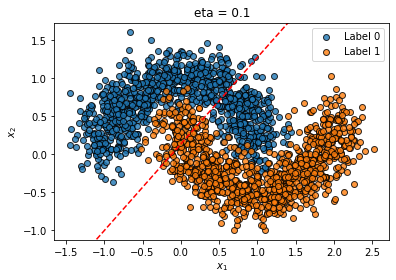

In [6]:
perceptron_part = perceptron1.steps[1][1]
perceptron_part.w_, len(perceptron_part.w_trace_)

def plot_line(slope, intercept, ax=None, shape='--', **kwargs):
    ax = plt.gca() if ax is None else ax
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())
    ax.plot(x_vals, y_vals, shape, **kwargs)

def plot_decision_boundary_from_weights_with_intercept(w, ax=None):
    slope = -w[1]/w[2]
    intercept = -w[0]/w[2]
    plot_line(slope, intercept, ax, shape='--', color='red')

plt.figure(figsize=(6, 4))
plt.title('eta = 0.1')
scatter_data_by_target_value(x_test, y_test)
plot_decision_boundary_from_weights_with_intercept(perceptron_part.w_)
plt.show()


### **Task 3: Neuron Network**


In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define the range of K values and learning rates
K_values = list(range(5, 41, 5))
learning_rates = [0.01, 0.001]

# Store results
results = []

# Loop over all combinations of K and learning rate
for K in K_values:
    for lr in learning_rates:
        # Initialize MLPClassifier with the given parameters
        mlp = MLPClassifier(hidden_layer_sizes=(K,), activation='relu', solver='sgd', 
                            learning_rate_init=lr, max_iter=1000, random_state=0)
        
        # Train the model
        mlp.fit(x_train, y_train)
        
        # Predict on test data
        y_pred = mlp.predict(x_test)
        
        # Calculate accuracy on test data
        acc = accuracy_score(y_test, y_pred)
        
        # Store the results
        results.append({'K': K, 'Learning Rate': lr, 'Accuracy': acc})

# Assuming results is a list of dictionaries as shown
max_acc = max(results, key=lambda x: x['Accuracy'])
best_acc = max_acc['Accuracy']
best_k = max_acc['K']
best_lr = max_acc['Learning Rate']

print(f"Maximum accuracy is {round(best_acc * 100, 3)}% achieved with K = {best_k} and Learning Rate = {best_lr}.")


# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results)

# Display the results
results_df


Maximum accuracy is 96.4% achieved with K = 20 and Learning Rate = 0.01.


,K,Learning Rate,Accuracy
0,5,0.010,0.8795
1,5,0.001,0.8660
2,10,0.010,0.8685
3,10,0.001,0.8655
4,15,0.010,0.9610
5,15,0.001,0.8725
6,20,0.010,0.9640
7,20,0.001,0.8825
8,25,0.010,0.9625
9,25,0.001,0.8675


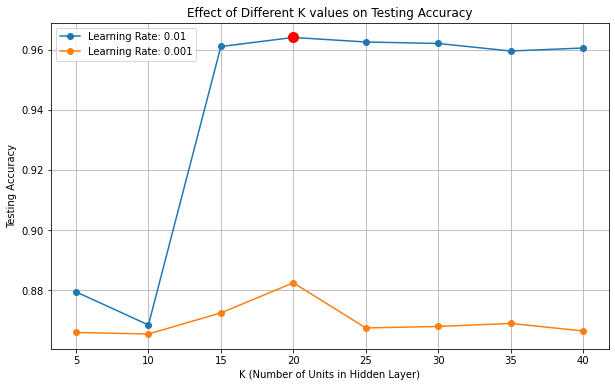

In [8]:
# Importing the required library and plotting again
import matplotlib.pyplot as plt

# Plotting the effect of different K values on accuracy for each learning rate
plt.figure(figsize=(10, 6))

for lr in learning_rates:
    subset = results_df[results_df['Learning Rate'] == lr]
    plt.plot(subset['K'], subset['Accuracy'], label=f'Learning Rate: {lr}', marker='o')
plt.plot(best_k, best_acc, marker='o', markersize=10, color='red')
plt.title('Effect of Different K values on Testing Accuracy')
plt.xlabel('K (Number of Units in Hidden Layer)')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()


From the graph, the best combination is $K = 20, eta = 0.01$ giving highest accuracy = $96.4\%$

Plotting decision boundary for the corresponding model

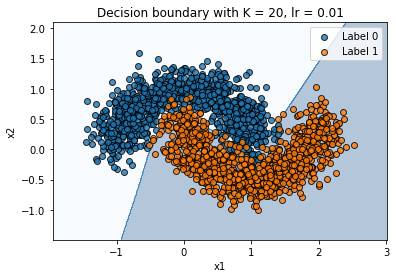

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

best_mlp = MLPClassifier(hidden_layer_sizes=20, activation='relu', solver='sgd', 
                         learning_rate_init=0.01, max_iter=1000, random_state=0)# Fit the MLP model
# Train the MLP model on the training data
best_mlp.fit(x_train, y_train)

# Define the grid
x_min, x_max = x_test[:, 0].min() - 0.5, x_test[:, 0].max() + 0.5
y_min, y_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict on the grid
Z = best_mlp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Blues')

# Scatter plot for testing data with a different color
scatter_data_by_target_value(x_test, y_test)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary with K = 20, lr = 0.01')
plt.legend()
plt.show()


### **Task 4: Explaination**

#### **Observation**

As can be seen from the graph, the perceptron model produces a linear boundary, which may not effectively separate the data. Conversely, the neural network (NN) exhibits a curved boundary that enables the data points to be separated more closely according to their true classes.

#### **Explanation**
   - Perceptron is a linear classifier. This means it tries to find a linear decision boundary (hyperplane) separate the classes. In this case, it is a straigh line for 2D.
   - Neural networks with multiple layers and non-linear activation functions can model complex, non-linear decision boundaries. In this case, because of the non-linear transformations by ReLU activation functions and the depth of the network (3 layers), the decision boundary is a curve, allowing it to fit closely to the true classes of non-linearly separable data.